In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

## Preparing labels

In [ ]:
data = pd.read_csv('stage_2_train_labels.csv').filter(['patientId', 'Target'])
data.head(5)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [ ]:
train_labels, val_labels = train_test_split(data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


In [ ]:
train_paths = [os.path.join('stage_2_train_images', image[0]) for image in train_labels]
val_paths = [os.path.join('stage_2_test_images', image[0]) for image in val_labels]

## Data Samples

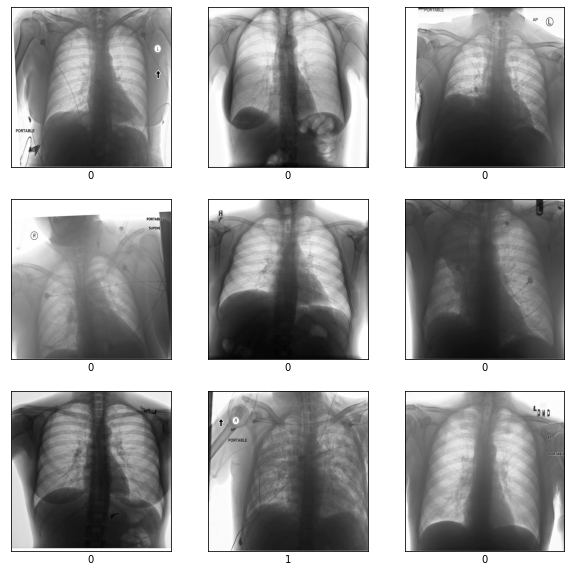

In [ ]:
def show(n=9):
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.xticks([])
        plt.yticks([])
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        plt.imshow(img_dcm.pixel_array, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])
show()

## Composing transformations

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()])

## Formatted Dataset 

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0
        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')
        label = self.labels[index][1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.paths)

Tensor:tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0118,  ..., 0.7804, 0.7765, 0.7333],
         [0.0039, 0.0039, 0.0235,  ..., 0.7843, 0.7843, 0.7412],
         [0.0039, 0.0078, 0.0314,  ..., 0.6667, 0.6667, 0.6314]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0118,  ..., 0.7804, 0.7765, 0.7333],
         [0.0039, 0.0039, 0.0235,  ..., 0.7843, 0.7843, 0.7412],
         [0.0039, 0.0078, 0.0314,  ..., 0.6667, 0.6667, 0.6314]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0

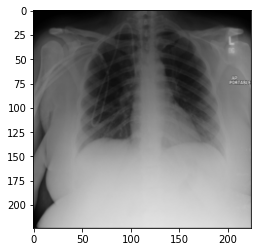

In [ ]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
image = iter(train_dataset)
img, label = next(image)
print(f'Tensor:{img}, Label:{label}')
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

## Train image shape

In [ ]:
img.shape

torch.Size([224, 224, 3])

## Load Training and Testing Dataset

In [ ]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)

## Check dataloader

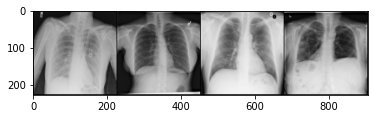

In [ ]:
batch = iter(train_loader)
images, labels = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

## Specify device object

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

## Load pre-trained AlexNet and fine-tune

In [ ]:
model = torchvision.models.alexnet(pretrained=True)
model.classifier[4] = nn.Linear(4096,1024)
model.classifier[6] = nn.Linear(1024,2)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Write a train code and RUN

In [ ]:
torch.cuda.empty_cache()
# Train the model
total_step = len(train_loader)
for epoch in range(10):
    # Training
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 2000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))


    # Validation
    correct = 0
    total = 0  
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total}')

2001it [04:22,  7.36it/s]

Epoch [1/10], Step [2000/3401], Loss: 0.5509


3401it [07:25,  7.63it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:47<00:00,  7.92it/s]


Epoch: 1/10, Val_Acc: 79.98677062988281


2001it [04:22,  7.23it/s]

Epoch [2/10], Step [2000/3401], Loss: 0.4827


3401it [07:30,  7.56it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:49<00:00,  7.70it/s]


Epoch: 2/10, Val_Acc: 78.53125762939453


2001it [04:28,  7.15it/s]

Epoch [3/10], Step [2000/3401], Loss: 0.2723


3401it [07:42,  7.36it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:51<00:00,  7.38it/s]


Epoch: 3/10, Val_Acc: 80.44988250732422


2001it [03:45,  8.19it/s]

Epoch [4/10], Step [2000/3401], Loss: 0.3261


3401it [06:25,  8.82it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:43<00:00,  8.62it/s]


Epoch: 4/10, Val_Acc: 80.25140380859375


2001it [04:04,  5.44it/s]

Epoch [5/10], Step [2000/3401], Loss: 0.2788


3401it [06:42,  8.45it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:47<00:00,  8.02it/s]


Epoch: 5/10, Val_Acc: 79.52365112304688


2001it [03:48,  8.45it/s]

Epoch [6/10], Step [2000/3401], Loss: 0.1878


3401it [06:21,  8.91it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:41<00:00,  9.16it/s]


Epoch: 6/10, Val_Acc: 80.54912567138672


2002it [03:32,  9.48it/s]

Epoch [7/10], Step [2000/3401], Loss: 0.1274


3401it [06:01,  9.42it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:39<00:00,  9.47it/s]


Epoch: 7/10, Val_Acc: 81.14456176757812


2000it [03:35,  8.52it/s]

Epoch [8/10], Step [2000/3401], Loss: 0.4206


3401it [06:10,  9.18it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:40<00:00,  9.42it/s]


Epoch: 8/10, Val_Acc: 80.44988250732422


2002it [03:37,  9.44it/s]

Epoch [9/10], Step [2000/3401], Loss: 0.2026


3401it [06:14,  9.09it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:41<00:00,  9.14it/s]


Epoch: 9/10, Val_Acc: 81.1776351928711


2001it [03:41,  8.30it/s]

Epoch [10/10], Step [2000/3401], Loss: 0.3124


3401it [06:21,  8.91it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:41<00:00,  9.21it/s]

Epoch: 10/10, Val_Acc: 80.91300201416016


In [ ]:
torch.save(model.state_dict(), "alexnet.pt")

In [ ]:
alexnet = torchvision.models.alexnet()
alexnet.classifier[4] = nn.Linear(4096,1024)
alexnet.classifier[6] = nn.Linear(1024,2)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alexnet.to(device)
alexnet.load_state_dict(torch.load("alexnet.pt"))

<All keys matched successfully>

In [ ]:
print(torch.__version__)

1.11.0+cu113


## Test model

In [ ]:
alexnet.eval()
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.max(alexnet(data),1)[1].item()
        preds.append(pred)
        labels.append(label)

100%|███████████████████████████████████████████████████████████████████████████████| 3023/3023 [01:04<00:00, 46.53it/s]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
acc = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
cm = confusion_matrix(labels, preds)

print(f"Val Accuracy {acc}")
print(f"Val precision {precision}")
print(f"Val Recall {recall}")
print(f"Val F1 {f1}")
print(f"Confusion Matrix {cm}")

Val Accuracy 0.8319550115779027
Val precision 0.7289719626168224
Val Recall 0.7397260273972602
Val F1 0.7343096234309623
Confusion Matrix [[1813  261]
 [ 247  702]]
